### Example benchmarking comparison between 2 Qiskit transpilers


In [11]:
from transpile_benchy.interface import QASMBench
import qiskit

qasm_bench = QASMBench(size="small", filter_list=["toffoli"])
print(qasm_bench)  # list of names of all possible circuits for qasm

# print(all_circuits)

from transpile_benchy.metrics import DepthMetric

from qiskit.circuit.library.standard_gates.x import CXGate, XGate

basis_gate = CXGate()

depth_metric = DepthMetric(basis_gate=basis_gate)

from qiskit.transpiler import CouplingMap

coupling_map = CouplingMap.from_grid(4, 5)

['qec_en_n5', 'qaoa_n3', 'grover_n2', 'toffoli_n3', 'hs4_n4', 'variational_n4', 'error_correctiond3_n5', 'deutsch_n2', 'ipea_n2', 'hhl_n7', 'bell_n4', 'quantumwalks_n2', 'wstate_n3', 'shor_n5', 'ising_n10', 'dnn_n2', 'basis_test_n4', 'basis_trotter_n4', 'basis_change_n3', 'cat_state_n4', 'bb84_n8', 'teleportation_n3', 'qrng_n4', 'fredkin_n3', 'qec_sm_n5', 'adder_n10', 'qaoa_n6', 'hhl_n10', 'qpe_n9', 'dnn_n8', 'adder_n4', 'linearsolver_n3', 'qft_n4', 'lpn_n5', 'pea_n5', 'iswap_n2', 'simon_n6']


In [12]:
from transpile_benchy.runner import CustomPassManager
from qiskit.transpiler.passes import (
    DenseLayout,
    LookaheadSwap,
    TrivialLayout,
    BasicSwap,
    SabreLayout,
    SabreSwap,
)
from qiskit.transpiler.passes import (
    ApplyLayout,
    SetLayout,
    FullAncillaAllocation,
    EnlargeWithAncilla,
)
from qiskit.transpiler import PassManager


class Trivial_Basic(CustomPassManager):
    """Custom pass manager."""

    def build_pre_process(self):
        return super().build_pre_process()

    def build_post_process(self):
        pm = PassManager()
        pm.append(depth_metric.get_pass())
        return pm

    def build_main_process(self):
        """Process the circuit."""
        pm = PassManager()
        pm.append(
            [
                TrivialLayout(self.coupling),
                FullAncillaAllocation(self.coupling),
                EnlargeWithAncilla(),
                ApplyLayout(),
                BasicSwap(self.coupling),
            ]
        )
        return pm


class SABRE(CustomPassManager):
    """Custom pass manager."""

    def build_pre_process(self):
        return super().build_pre_process()

    def build_post_process(self):
        pm = PassManager()
        pm.append(depth_metric.get_pass())
        return pm

    def build_main_process(self):
        """Process the circuit."""
        pm = PassManager()
        pm.append(
            [
                SabreLayout(self.coupling),
                # FullAncillaAllocation(coupling_map),
                # EnlargeWithAncilla(),
                # ApplyLayout(),
                SabreSwap(self.coupling),
            ]
        )
        return pm

In [13]:
import logging
from transpile_benchy.benchmark import Benchmark

# Create a specific logger for transpile_benchy and set its level to DEBUG
transpile_benchy_logger = logging.getLogger("transpile_benchy")
# transpile_benchy_logger.setLevel(logging.DEBUG)
transpile_benchy_logger.setLevel(logging.INFO)

# Silence the qiskit logger by setting its level to WARNING or higher
qiskit_logger = logging.getLogger("qiskit")
qiskit_logger.setLevel(logging.WARNING)

benchmark = Benchmark(
    [Trivial_Basic(coupling=coupling_map), SABRE(coupling=coupling_map)],
    [qasm_bench],
    [depth_metric],
    transpile_benchy_logger,
)
benchmark.run()

INFO:transpile_benchy:Running benchmarks for circuits...
Running circuits for QASMBench:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:transpile_benchy:Transpiler Trivial_Basic, toffoli_n3: 15.0
INFO:transpile_benchy:Transpiler Trivial_Basic, toffoli_n3: 15.0
INFO:transpile_benchy:Transpiler Trivial_Basic, toffoli_n3: 15.0
INFO:transpile_benchy:Transpiler SABRE, toffoli_n3: 8.0
INFO:transpile_benchy:Transpiler SABRE, toffoli_n3: 9.0
INFO:transpile_benchy:Transpiler SABRE, toffoli_n3: 9.0
Running circuits for QASMBench: 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


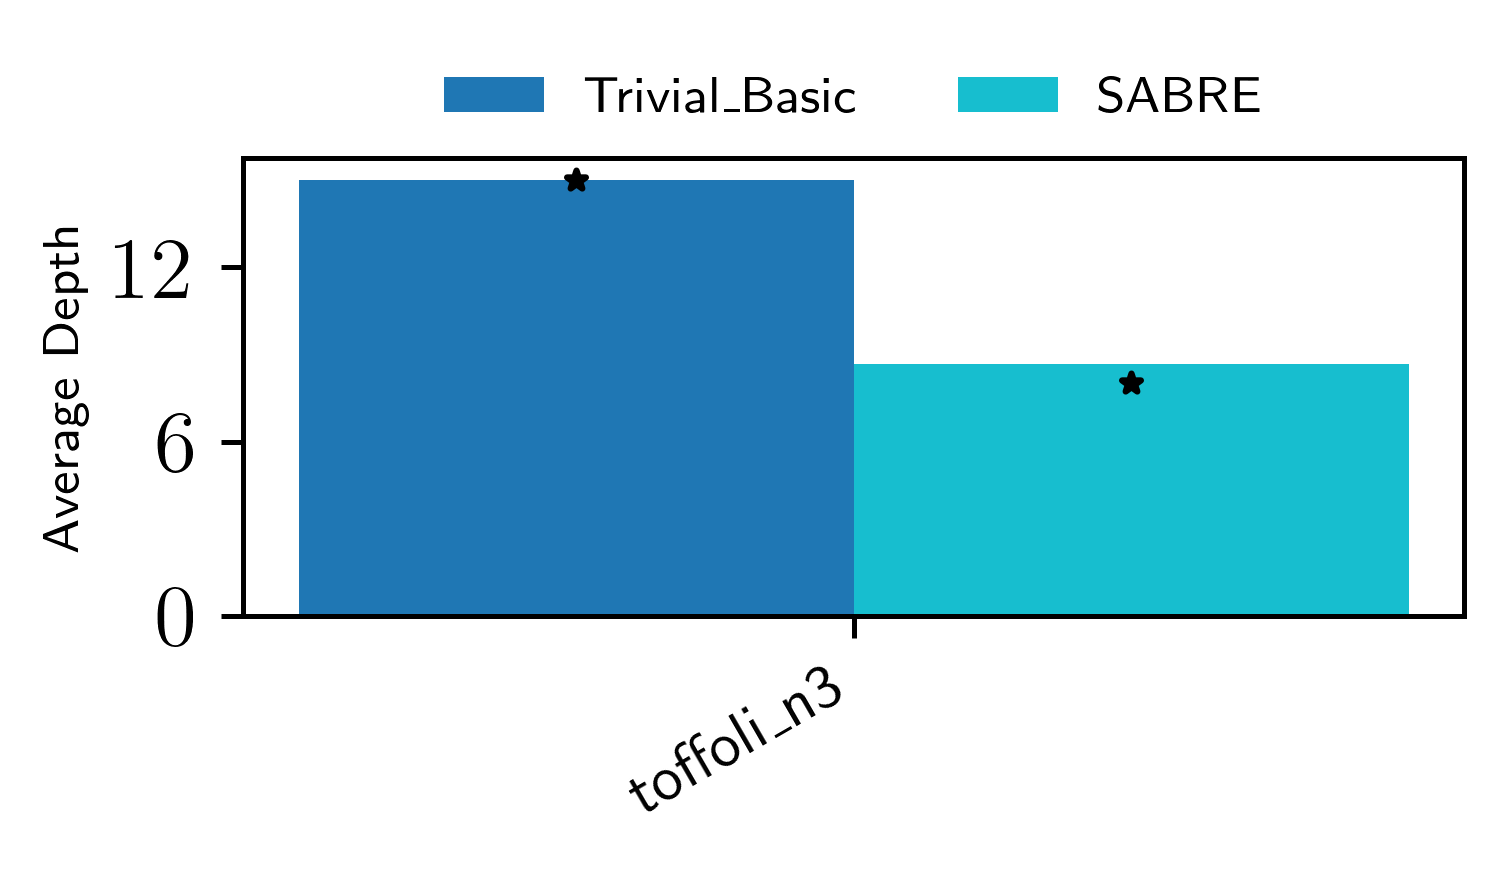

In [14]:
benchmark.plot(save=True)